In [9]:
pip install streamlit

In [10]:
# Import libraries. You may or may not use all of these.
!pip install -q git+https://github.com/tensorflow/docs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error

  Preparing metadata (setup.py) ... done
Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [11]:
# Import data
!wget https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
dataset = pd.read_csv('insurance.csv')
dataset.tail()

--2025-09-06 15:29:34--  https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.3.33, 104.26.2.33, 172.67.70.149, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.3.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50264 (49K) [text/csv]
Saving to: ‘insurance.csv.1’

insurance.csv.1     100%[===================>]  49.09K  --.-KB/s    in 0.01s   

2025-09-06 15:29:34 (4.51 MB/s) - ‘insurance.csv.1’ saved [50264/50264]



,age,sex,bmi,children,smoker,region,expenses
1333,50,male,31.0,3,no,northwest,10600.55
1334,18,female,31.9,0,no,northeast,2205.98
1335,18,female,36.9,0,no,southeast,1629.83
1336,21,female,25.8,0,no,southwest,2007.95
1337,61,female,29.1,0,yes,northwest,29141.36


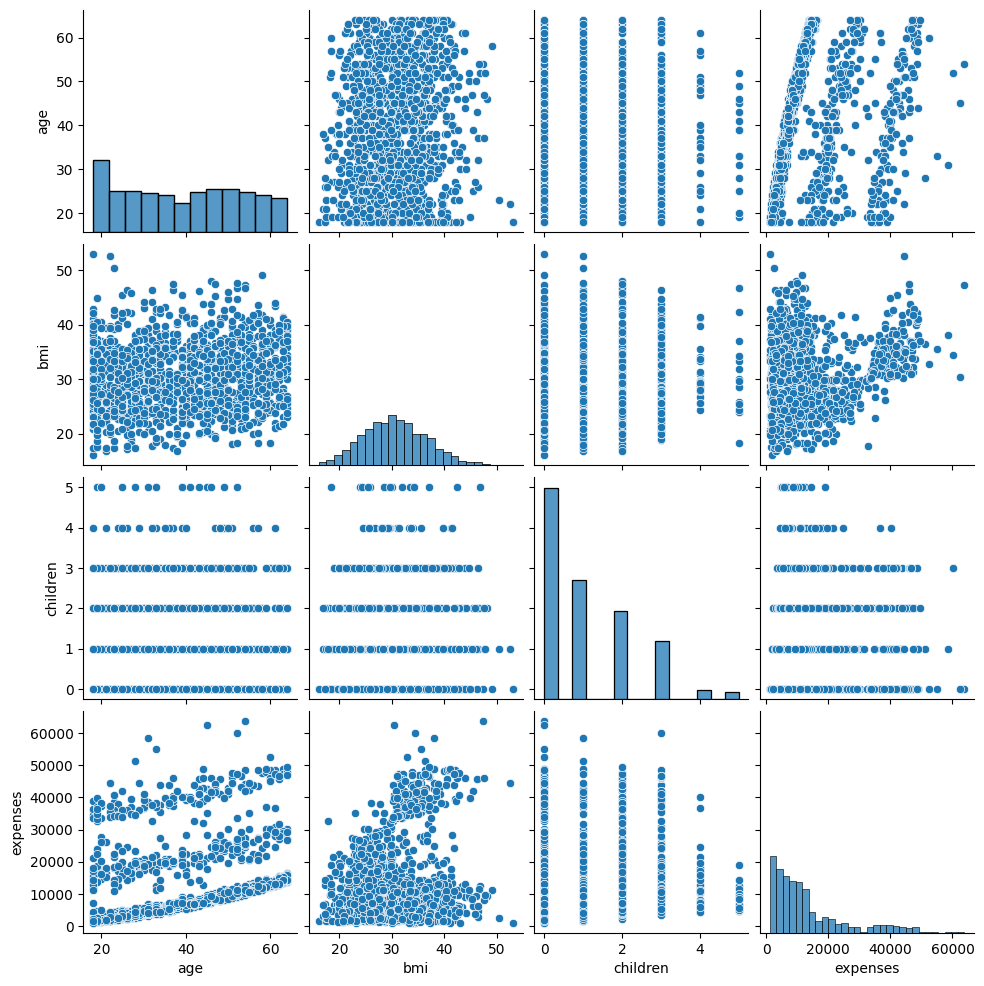

In [12]:
import seaborn as sns
sns.pairplot(dataset)

In [13]:
df = dataset

X = df.drop(columns=['expenses'])  # Features
y = np.log(df['expenses'])  # Target

numFeat = ['age', 'bmi', 'children']
catFeat = ['sex', 'smoker', 'region']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numFeat),
        ('cat', OneHotEncoder(), catFeat)
    ])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1)  # Single output for regression
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='mae', metrics=['mae'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

history = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=16,
                    validation_split=0.2,
                    callbacks=[early_stopping, lr_scheduler],
                    verbose=1)

y_pred = np.exp(model.predict(X_test).flatten())  # Reverse log-transform for predictions
y_test_original = np.exp(y_test)  # Reverse log-transform for true values

mae = mean_absolute_error(y_test_original, y_pred)
print(f"Mean Absolute Error: {mae}")


Epoch 1/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 8.8752 - mae: 8.8752 - val_loss: 8.1761 - val_mae: 8.1761 - learning_rate: 0.0010
Epoch 2/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.2646 - mae: 8.2646 - val_loss: 7.3368 - val_mae: 7.3368 - learning_rate: 0.0010
Epoch 3/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.3227 - mae: 7.3227 - val_loss: 6.1274 - val_mae: 6.1274 - learning_rate: 0.0010
Epoch 4/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.0371 - mae: 6.0371 - val_loss: 4.3567 - val_mae: 4.3567 - learning_rate: 0.0010
Epoch 5/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.2233 - mae: 4.2233 - val_loss: 2.1379 - val_mae: 2.1379 - learning_rate: 0.0010
Epoch 6/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.6579 - mae: 2.6579 - val_loss: 0.9973 - val_mae: 0.9973 - learning_rate: 0.0010
Epoch 7/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.1020 - mae: 2.1020 - val_loss: 0.8379 - val_mae: 0.8379 - learning_rate: 0.0010
Epoch 8/100


(array([133.,  75.,  21.,   7.,  12.,   9.,   3.,   4.,   2.,   2.]),
 array([ 1186.90454102,  7352.40136719, 13517.8984375 , 19683.39648438,
        25848.89257812, 32014.38867188, 38179.890625  , 44345.38671875,
        50510.8828125 , 56676.37890625, 62841.87890625]),
 <BarContainer object of 10 artists>)

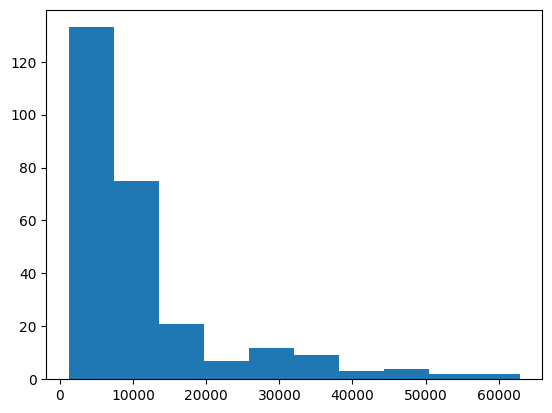

In [14]:
plt.hist(y_pred)

2025-09-06 15:30:15.074 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-06 15:30:15.075 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-06 15:30:15.482 
  command:

    streamlit run /usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-09-06 15:30:15.483 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-06 15:30:15.485 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-06 15:30:15.486 No runtime found, using MemoryCacheStorageManager
2025-09-06 15:30:15.488 No runtime found, using MemoryCacheStorageManager
2025-09-06 15:30:15.489 Thread 'MainThread': missing ScriptRunContext! This warning ca

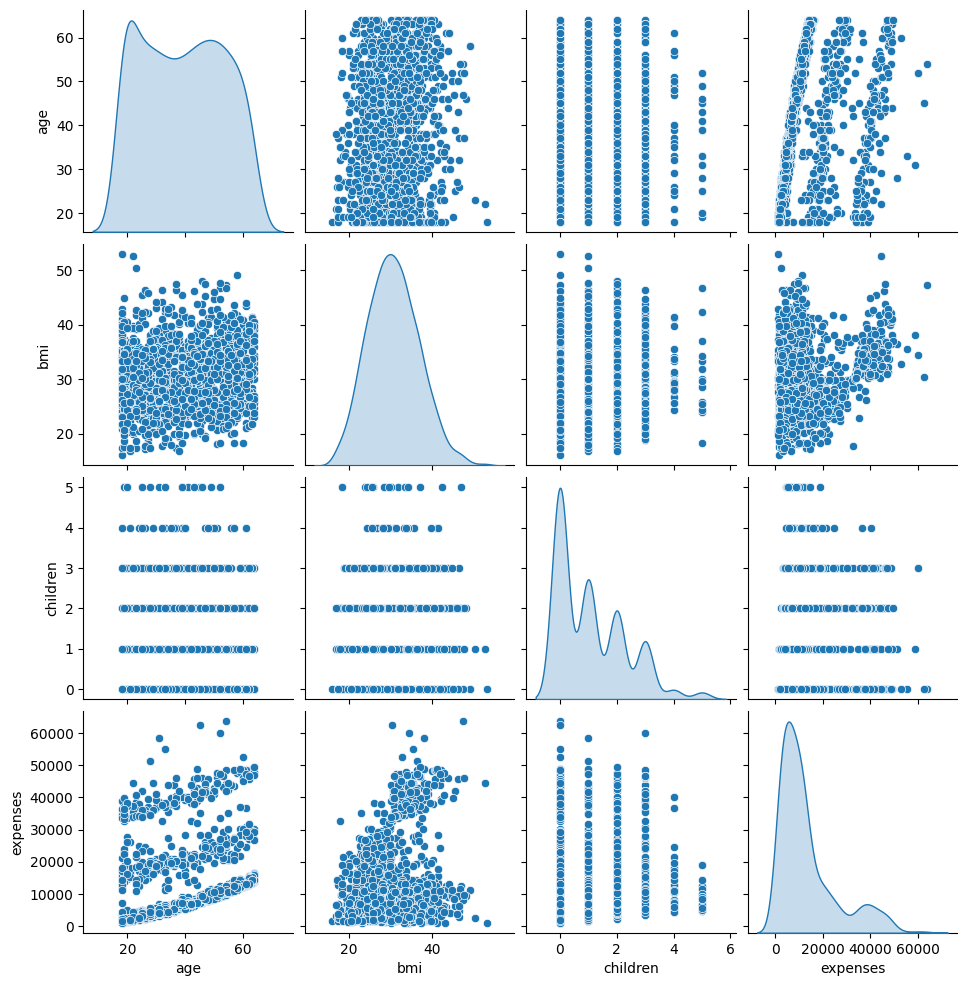

In [15]:
import streamlit as st
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error
import tensorflow as tf

# --------------------
# Page Config
# --------------------
st.set_page_config(page_title="Medical Insurance Cost Predictor", layout="wide")
st.title("💰 Medical Insurance Cost Predictor")

# --------------------
# Load Dataset
# --------------------
@st.cache_data
def load_data():
    url = "https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv"
    df = pd.read_csv(url)
    return df


df = load_data()
st.subheader("Dataset Preview")
st.dataframe(df.head())

# --------------------
# Data Visualization
# --------------------
with st.expander("📊 Explore Data"):
    st.write("Pairplot of features")
    fig = sns.pairplot(df, diag_kind="kde")
    st.pyplot(fig)

# --------------------
# Data Preprocessing
# --------------------
X = df.drop(columns=["expenses"])
y = np.log(df["expenses"])  # log-transform target

numFeat = ["age", "bmi", "children"]
catFeat = ["sex", "smoker", "region"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numFeat),
        ("cat", OneHotEncoder(), catFeat),
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=11
)

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# --------------------
# Model Definition
# --------------------
def create_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(input_shape,)),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1),
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss="mae",
        metrics=["mae"],
    )
    return model


# --------------------
# Train Model Button
# --------------------
if st.button("🚀 Train Model"):
    model = create_model(X_train.shape[1])
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=10, restore_best_weights=True
    )
    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=5
    )

    history = model.fit(
        X_train,
        y_train,
        epochs=100,
        batch_size=16,
        validation_split=0.2,
        callbacks=[early_stopping, lr_scheduler],
        verbose=0,
    )

    # Plot training history
    st.subheader("📈 Training History")
    fig, ax = plt.subplots()
    ax.plot(history.history["mae"], label="Train MAE")
    ax.plot(history.history["val_mae"], label="Val MAE")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("MAE")
    ax.legend()
    st.pyplot(fig)

    # Evaluate
    y_pred = np.exp(model.predict(X_test).flatten())
    y_test_original = np.exp(y_test)
    mae = mean_absolute_error(y_test_original, y_pred)
    st.success(f"✅ Mean Absolute Error: {mae:.2f} expenses")

    # Plot True vs Predictions
    st.subheader("🎯 Predictions vs True Values")
    fig2, ax2 = plt.subplots()
    ax2.scatter(y_test_original, y_pred, alpha=0.6)
    ax2.plot([0, max(y_test_original)], [0, max(y_test_original)], "r--")
    ax2.set_xlabel("True Values")
    ax2.set_ylabel("Predicted Values")
    st.pyplot(fig2)

    # --------------------
    # User Input for Prediction
    # --------------------
    st.subheader("🔮 Try Your Own Prediction")
    col1, col2, col3 = st.columns(3)
    with col1:
        age = st.slider("Age", 18, 64, 30)
        bmi = st.slider("BMI", 15.0, 40.0, 25.0)
    with col2:
        children = st.number_input("Children", 0, 5, 1)
        sex = st.selectbox("Sex", ["male", "female"])
    with col3:
        smoker = st.selectbox("Smoker", ["yes", "no"])
        region = st.selectbox("Region", df["region"].unique())

    if st.button("Predict My Expense"):
        input_df = pd.DataFrame(
            [[age, bmi, children, sex, smoker, region]],
            columns=["age", "bmi", "children", "sex", "smoker", "region"],
        )
        input_transformed = preprocessor.transform(input_df)
        pred = np.exp(model.predict(input_transformed).flatten()[0])
        st.info(f"💡 Estimated Medical Expense: **${pred:,.2f}**")
